In [1]:
# experiment tracker
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


### Notes
### local vs CC seem to huge FLOP difference during setup

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=470.74 Hz, eta=0:00:00, total=0:00:00, wall=11:09 EST
Done!


In [2]:
def get_tracker_data(experiment_name, logdir, use_cuda, read_flops):
    # impact tracker log
    tracker_df =  load_data_into_frame(logdir)

    if use_cuda:
        power_df = tracker_df[0][['timestamp','rapl_power_draw_absolute','rapl_estimated_attributable_power_draw','nvidia_draw_absolute','nvidia_estimated_attributable_power_draw']]
        power_df['total_attributable_power_draw'] = power_df['rapl_estimated_attributable_power_draw'] + power_df['nvidia_estimated_attributable_power_draw']

    else:
        power_df = tracker_df[0][['timestamp','rapl_power_draw_absolute','rapl_estimated_attributable_power_draw']]
        power_df['total_attributable_power_draw'] = power_df['rapl_estimated_attributable_power_draw']
        
    # start time from 0
    power_df['timestamp'] = power_df['timestamp'] - power_df['timestamp'][0]
    power_df['experiment_name'] = experiment_name

    # papi log
    flops_df = None
    total_duration = 0
    if read_flops:
        compute_flops_csv = logdir + 'compute_costs_flop.csv'
        flops_df = pd.read_csv(compute_flops_csv)
        flops_df['experiment_name'] = experiment_name
    
        flops_df['start_time'] = flops_df['start_time'] - flops_df['start_time'][0]

        # Aggregate power draws per epoch for each papi context calculation (i.e. setup, axial, aggr etc))
        epoch_power_draw_list = []
        epoch_timestamps = list(flops_df['start_time'].values[1:]) + [power_df['timestamp'].values[-1]]
        
        for e, epoch in enumerate(epoch_timestamps):
            epoch_power_draw = power_df[power_df['timestamp'] < epoch]['total_attributable_power_draw'].sum() # this is sum upto the epoch (not interval)
            if e == 0:
                epoch_power_draw_list.append(epoch_power_draw)  
            else:
                epoch_power_draw_list.append(epoch_power_draw - epoch_power_draw_list[e-1]) #Subtracting previous stage power-draw 

        flops_df['epoch_power_draw'] = epoch_power_draw_list
    

    data_interface = DataInterface([logdir])
    total_power = data_interface.total_power
    total_carbon = data_interface.kg_carbon
    PUE = data_interface.PUE
    total_duration = (power_df['timestamp'].values[-1]-power_df['timestamp'].values[0])/3600

    tracker_summary_df = pd.DataFrame(columns=['experiment_name','total_power','total_carbon','PUE','total_duration'])
    tracker_summary_df.loc[0] = [experiment_name,total_power,total_carbon,PUE,total_duration]
    return power_df, flops_df, tracker_summary_df
 



In [11]:
experiment_dict = {
                #    'FastSurfer_local_cpu':('./logs/track_sub_000_benchmark/',False), 
                #    'FastSurfer_CC_cpu':('./logs/CC_cpu_test/',False),
                #    'FastSurfer_CC_gpu':('./logs/CC_gpu_test/',True),
                   'autorecon1_local_test_1':('/home/nikhil/projects/neurodocker/nipype_tutorial/code/logs/ReconAll_test_local_cpu/',False),
                   'autorecon2-3_local_test_1':('/home/nikhil/projects/neurodocker/nipype_tutorial/code/logs/ReconAll_test_location_override/',False),
                   'autorecon1_CC_test_1':('/home/nikhil/projects/neurodocker/nipype_tutorial/code/logs/ReconAll_test_CC_cpu/',False),
                   'autorecon1_CC_ukb_1':('/home/nikhil/projects/neurodocker/nipype_tutorial/code/logs/ReconAll_ukb_CC_cpu/',False)
                   }

read_flops = True

power_df_concat = pd.DataFrame()
flops_df_concat = pd.DataFrame()
tracker_summary_df_concat = pd.DataFrame()

for k,v in experiment_dict.items():
    power_df, flops_df, tracker_summary_df = get_tracker_data(k, v[0], v[1], read_flops)
    power_df_concat = power_df_concat.append(power_df)
    flops_df_concat = flops_df_concat.append(flops_df)
    tracker_summary_df_concat = tracker_summary_df_concat.append(tracker_summary_df)


In [12]:
tracker_summary_df_concat

,experiment_name,total_power,total_carbon,PUE,total_duration
0,autorecon1_local_test_1,0.004447,0.000201,1.58,0.254857
0,autorecon2-3_local_test_1,0.084227,0.003808,1.58,7.306257
0,autorecon1_CC_test_1,0.003813,0.000114,1.58,0.346818
0,autorecon1_CC_ukb_1,0.023032,0.000691,1.58,0.246087


## Plots
### Summary power

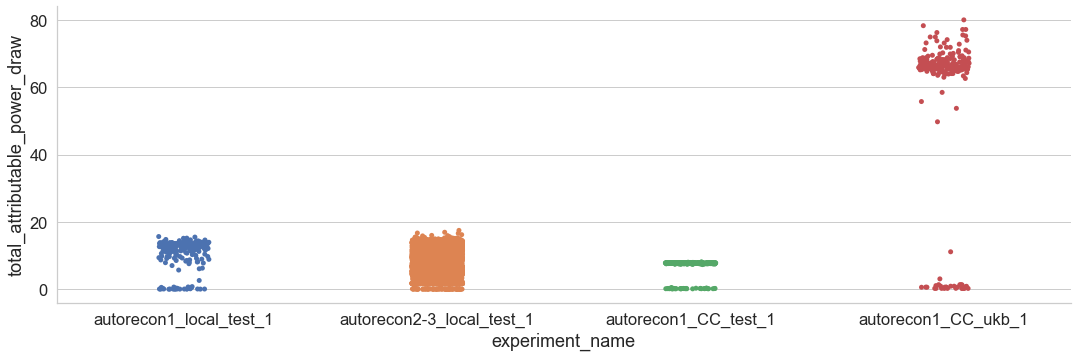

In [13]:
plot_df = power_df_concat.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='total_attributable_power_draw', x='experiment_name', data=plot_df, kind='strip',aspect=3)


### Flops vs Power

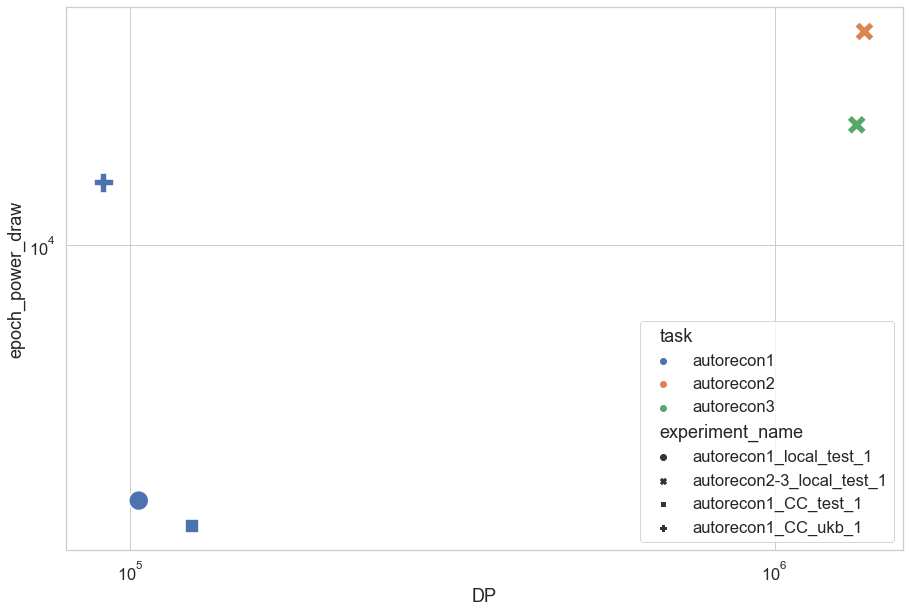

In [14]:
plot_df = flops_df_concat.copy()

sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,10),sharex=False,sharey=False)
    g = sns.scatterplot(y='epoch_power_draw', x='DP', hue='task', style='experiment_name', s=400, data=plot_df)
    g.set(xscale='log',yscale='log')


### Power trace

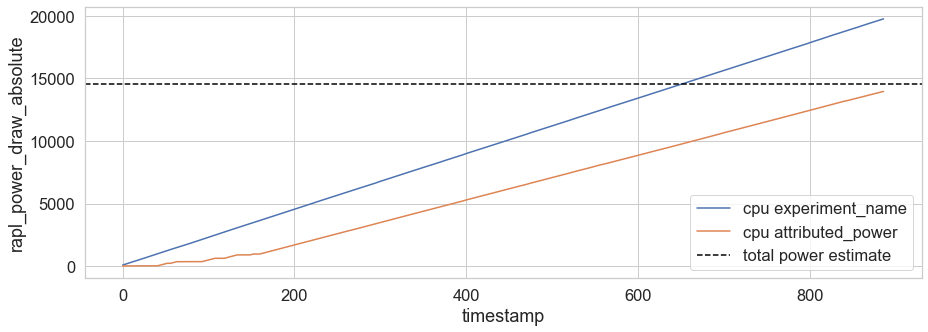

In [16]:
experiment_name = 'autorecon1_CC_ukb_1'

plot_df = power_df_concat[power_df_concat['experiment_name']==experiment_name].copy()
total_power = tracker_summary_df_concat[tracker_summary_df_concat['experiment_name']==experiment_name]['total_power'].values[0]
PUE = tracker_summary_df_concat[tracker_summary_df_concat['experiment_name']==experiment_name]['PUE'].values[0]

use_cuda = False
plot_epochs = False

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(figsize=(15,5),sharex=False,sharey=False)

    g = sns.lineplot(plot_df['timestamp'],plot_df['rapl_power_draw_absolute'].cumsum(),label='cpu absolute_power')
    g = sns.lineplot(plot_df['timestamp'],plot_df['rapl_estimated_attributable_power_draw'].cumsum(),label='cpu attributed_power')

    if use_cuda:
        g = sns.lineplot(plot_df['timestamp'],plot_df['nvidia_draw_absolute'].cumsum(),label='gpu total_power')
        g = sns.lineplot(plot_df['timestamp'],plot_df['nvidia_estimated_attributable_power_draw'].cumsum(),label='gpu attributed_power')

    if plot_epochs: 
        for e in epochs:
            g = plt.axvline(e, linestyle='-',c='purple')
        
    g = plt.axhline(1000000*total_power/PUE, linestyle='--',c='black',label='total power estimate')
    
    plt.legend()


In [17]:
# experiment tracker
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../experiment-impact-tracker/')

from experiment_impact_tracker.compute_tracker import ImpactTracker
import tempfile
import time

def func1():
    count = 0
    for i in range(100):
        count += i
    return count

def func2():
    count = 0
    for i in range(100):
        count += i**2
    return count

In [2]:
experiment1 = tempfile.mkdtemp()
experiment2 = tempfile.mkdtemp()

print('Tracker 1')
tracker1  = ImpactTracker(experiment1)
print(tracker1.launched)
with tracker1:
    func1()
    print(tracker1.launched)

time.sleep(1)
print('Tracker 2')
tracker2  = ImpactTracker(experiment2)
print(tracker2.launched)
with tracker2:
    print('Starting context')
    print(tracker2.launched)
    print('Starting func2')
    func2()
    print(tracker2.launched)

INFO:Gathering system info for reproducibility...
Tracker 1
INFO:Requested http://ipinfo.io/json
INFO:Done initial setup and information gathering...
False
INFO:Requesting thread shutdown.
INFO:Starting process to monitor power
True
INFO:Starting - Logging final info.
INFO:Done - Logging final info.
INFO:Gathering system info for reproducibility...
Tracker 2
INFO:Done initial setup and information gathering...
experiment_impact_tracker.compute_tracker.ImpactTracker - ERROR - Encountered exception when launching power monitor thread.
experiment_impact_tracker.compute_tracker.ImpactTracker - ERROR - Encountered exception when launching power monitor thread.
ERROR:Encountered exception when launching power monitor thread.
--- Logging error ---
Traceback (most recent call last):
  File "../../experiment-impact-tracker/experiment_impact_tracker/compute_tracker.py", line 293, in launch_impact_monitor
    multiprocessing.set_start_method("fork")
  File "/home/nikhil/anaconda3/envs/green_compu

RuntimeError: context has already been set

In [48]:
from experiment_impact_tracker.emissions.get_region_metrics import \
    get_current_region_info_cached, get_current_location

In [46]:
region_info = get_current_region_info_cached()
region_info

({'type': 'Feature',
  'geometry': <shapely.geometry.multipolygon.MultiPolygon at 0x7fcb0ff87d50>,
  'properties': {'zoneName': 'CA-ON'},
  'id': 'CA-ON'},
 {'_source': 'https://github.com/tmrowco/electricitymap-contrib/blob/master/config/co2eq_parameters.json (ElectricityMap Average, 2019)',
  'carbonIntensity': 45.21034939608702,
  'fossilFuelRatio': 0.06218982738518038,
  'renewableRatio': 0.32982581430396574})

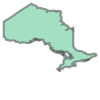

In [47]:
region_info[0]['geometry']

In [50]:
get_current_location()

INFO:Requested http://ipinfo.io/json


(43.5789, -79.6583)